## COVID Hospitalization

### Binary classification model tuning for hospitalization prediction

Here we will attempt to create a model for hospitalization predictions based on demographic data as well time of the year (month).  
We will try different classification techniques and look at the f1 score, balanced accuracy and recall as our evaluation metrics with greater emphasis on **balanced accuracy** and **recall**. Since our target is predicitng hospitalization, we will attempt to get as high recall as possible so that we have as less false negatives as possible. It may be ok to have false positives and have people visiting the doctor than have false negatives where people who need care will not be warned. We have imbalanced classes in target variable so balanced accuracy will be important to look at.   

In [416]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,f1_score, 
                             recall_score, precision_score, balanced_accuracy_score, RocCurveDisplay)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, SMOTEN
from imblearn.combine import SMOTEENN

import pickle

In [443]:
df_surv_hosp=pd.read_csv('../data/clean_data/covid_surveillance_hospitalization.csv')

In [444]:
df_surv_hosp.head()

,case_month,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn
0,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
1,2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
2,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No
3,2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
4,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No


In [445]:
df_surv_hosp.shape

(114644, 9)

In [446]:
df_surv_hosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114644 entries, 0 to 114643
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   case_month      114644 non-null  object
 1   res_state       114644 non-null  object
 2   age_group       114644 non-null  object
 3   sex             114644 non-null  object
 4   race            114644 non-null  object
 5   ethnicity       114644 non-null  object
 6   symptom_status  114644 non-null  object
 7   hosp_yn         114644 non-null  int64 
 8   death_yn        114644 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.9+ MB


### Creating month as a new feature

In [447]:
def create_month(df):
    
    #converting case_month to DateTime
    df['case_month']=pd.to_datetime(df['case_month'])

    #Extracting month as a feature for the model
    df['month']=df['case_month'].dt.month

    #All our columns will be treated as categorical. Converting month column to object type.
    df['month']=df['month'].astype(object)

    return df

In [448]:
df_surv_hosp=create_month(df_surv_hosp)

In [449]:
df_surv_hosp.head()

,case_month,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn,month
0,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No,3
1,2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No,3
2,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No,3
3,2020-03-01,PA,65+ years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No,3
4,2020-03-01,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,Symptomatic,1,No,3


In [450]:
df_surv_hosp.shape

(114644, 10)

### Baseline- Model Benchmark

In [451]:
df_surv_hosp['hosp_yn'].value_counts(normalize=True)

0    0.919411
1    0.080589
Name: hosp_yn, dtype: float64

We have **highly imbalanced classes** for our target variable.  
Our baseline accuracy is 92%

### X, y, train test split

In [634]:
#Creating X and y
X=df_surv_hosp.drop(columns=['case_month','symptom_status','death_yn','hosp_yn'])
y=df_surv_hosp['hosp_yn']
features=list(X.columns)
features

['res_state', 'age_group', 'sex', 'race', 'ethnicity', 'month']

In [453]:
X.shape, y.shape

((114644, 6), (114644,))

In [454]:
X.head()

,res_state,age_group,sex,race,ethnicity,month
0,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,3
1,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,3
2,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,3
3,PA,65+ years,Female,White,Non-Hispanic/Latino,3
4,NJ,18 to 49 years,Male,Black,Non-Hispanic/Latino,3


In [455]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: hosp_yn, dtype: int64

In [493]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y, random_state=42)

In [494]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((85983, 6), (85983,), (28661, 6), (28661,))

In [495]:
X_train

,res_state,age_group,sex,race,ethnicity,month
73768,WI,0 - 17 years,Male,White,Non-Hispanic/Latino,11
106870,TX,50 to 64 years,Female,White,Hispanic/Latino,5
28926,TX,18 to 49 years,Female,Asian,Non-Hispanic/Latino,12
78656,NJ,0 - 17 years,Male,Black,Non-Hispanic/Latino,12
1882,OH,50 to 64 years,Male,White,Non-Hispanic/Latino,5
...,...,...,...,...,...,...
28000,VA,18 to 49 years,Female,Asian,Non-Hispanic/Latino,12
40267,SC,18 to 49 years,Female,White,Non-Hispanic/Latino,1
62767,NJ,50 to 64 years,Female,White,Non-Hispanic/Latino,8
25632,VA,65+ years,Female,Black,Non-Hispanic/Latino,12


### One hot encoding train and test

Defining function to transform train and test sets:

In [590]:
def transform_train(df, features):
    '''This function gets dummies for features 
    and saves column lists of dummies for training set'''
       
    #getting list of columns without dropping as a guide for reference:
    col_wo_drop=pd.get_dummies(df)
    dropped_col_guide=col_wo_drop.columns

    #dummyfying columns:
    df_dum=pd.get_dummies(data=df, drop_first=True)   
    
    
    #saving list of dummy columns
    df_dummies = [col for col in df_dum if "_" in col and col.rsplit("_",1)[0] in features]
    
    return ( dropped_col_guide, df_dum, df_dummies)

In [589]:
def transform_test(df, df_dummies, features):
    '''This function gets dummies for features 
    for training set and removes the columns not created during training
    and adds the columns missing from test set'''
        
    #dummyfying columns:
    df_dum=pd.get_dummies(data=df, drop_first=True)   
    
    #Removing additional dummy columns
    for col in df_dum.columns:
        if ("_" in col) and (col.rsplit("_",1)[0] in features) and col not in df_dummies:
            print("Removing additional feature {}".format(col))
            df_dum.drop(col, axis=1, inplace=True)
            
    #Adding missing columns        
    for col in df_dummies:
        if col not in df_dum.columns:
            print("Adding missing feature {}".format(col))
            df_dum[col] = 0
    
    return df_dum

In [498]:
#Getting some future warning with this-- tried finding the solution online but this one seems to be an open issue so far
#not suppressing it for the record

dropped_col_guide, X_train_dum, X_train_dummies=transform_train(X_train, features)

C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [499]:
pd.DataFrame(X_train_dummies).to_csv('../streamlit/pages/models/X_train_dummies.csv', index=False)

In [635]:
X_train_dum.head();

In [501]:
#Getting some future warning with this-- tried finding the solution online but this one seems to be an open issue so far
#not suppressing it for the record

X_test_dum=transform_test(X_test, X_train_dummies, features)

Removing additional feature res_state_HI


C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [502]:
X_train_dum.shape, y_train.shape, X_test_dum.shape, y_test.shape

((85983, 63), (85983,), (28661, 63), (28661,))

In [503]:
X_test_dum=X_test_dum[X_train_dummies]

In [504]:
X_train_dum.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85983 entries, 73768 to 9539
Data columns (total 63 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   res_state_AL                                 85983 non-null  uint8
 1   res_state_AR                                 85983 non-null  uint8
 2   res_state_AZ                                 85983 non-null  uint8
 3   res_state_CA                                 85983 non-null  uint8
 4   res_state_CO                                 85983 non-null  uint8
 5   res_state_CT                                 85983 non-null  uint8
 6   res_state_DC                                 85983 non-null  uint8
 7   res_state_FL                                 85983 non-null  uint8
 8   res_state_GA                                 85983 non-null  uint8
 9   res_state_IA                                 85983 non-null  uint8
 10  res_state_ID       

### Model Tuning

**Model 1: Logistic Regression**

In [55]:
logreg=LogisticRegression(random_state=42,n_jobs=-1)

In [56]:
logreg.fit(X_train_dum, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [64]:
#Creating a dataframe to save model metrics
eval_df=pd.DataFrame(columns=['model_no', 'comment', 'training_accuracy', 'testing_accuracy', 'f1score_train', 'f1score_test', 'balanced_accuracy', 'recall', 'precision'])

In [77]:
def model_eval(model, model_no, X_train, y_train, X_test, y_test, comment):
    
    '''This function calculates and displays major model evaluation metrics'''
    
    ConfusionMatrixDisplay.from_estimator(model,X_test, y_test, cmap='Blues')
        
    print(f'Model: {model}')
    #Calculating accuracy score
    training_accuracy=model.score(X_train, y_train)
    print(f'Training_score: {training_accuracy}')
    testing_accuracy=model.score(X_test, y_test)
    print(f'Testing score: {testing_accuracy}')
    

    #Calculating F1 scores
    pred_train=model.predict(X_train)
    pred=model.predict(X_test)
    f1score_train=f1_score(y_train,pred_train)
    print(f'F1 Train score: {f1score_train}')
    f1score_test=f1_score(y_test,pred)
    print(f'F1 Test score: {f1score_test}')
    
    balanced_accuracy=balanced_accuracy_score(y_test, pred)
    print(f'Balanced Accuracy: {balanced_accuracy}')  
    recall=recall_score(y_test, pred, pos_label = 1)
    print(f'Recall: {recall}')   
    precision=precision_score(y_test, pred, pos_label = 1)
    print(f'Precision: {precision}')
    #Saving metrics
    eval_df.loc[model_no-1,:]=[ model_no, comment, training_accuracy, testing_accuracy, f1score_train, f1score_test, balanced_accuracy, recall, precision]
    
    
    return eval_df

Model: LogisticRegression(n_jobs=-1, random_state=42)
Training_score: 0.9218915366991149
Testing score: 0.9212867659886257
F1 Train score: 0.12574850299401197
F1 Test score: 0.11529411764705882
Balanced Accuracy: 0.5300535429050476
Recall: 0.06363636363636363
Precision: 0.6125


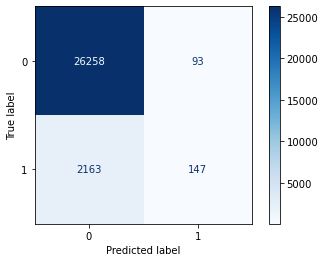

In [78]:
evaluation_df=model_eval(logreg, 1, X_train_dum, y_train, X_test_dum, y_test, 'logistic regression')

We have very low F1 score. The balanced accuracy and Recall are also very low.   
This may be because of highly imbalanced classes. Will try some undersampling and oversampling techniques.


**Model 2: Logistic Regression with Undersampling**

In [69]:
#Help from lesson 7.06
rus=RandomUnderSampler(random_state=42)

X_train_rus,y_train_rus=rus.fit_resample(X_train_dum,y_train)

In [70]:
X_train_rus.shape, y_train_rus.shape

((13858, 63), (13858,))

In [71]:
logreg_under=LogisticRegression(solver='liblinear')

logreg_under.fit(X_train_rus,y_train_rus)

LogisticRegression(solver='liblinear')

Model: LogisticRegression(solver='liblinear')
Training_score: 0.7497474383027853
Testing score: 0.7529395345591571
F1 Train score: 0.7510409188801147
F1 Test score: 0.3274764934941589
Balanced Accuracy: 0.7499200684203151
Recall: 0.7463203463203463
Precision: 0.20975787808735855


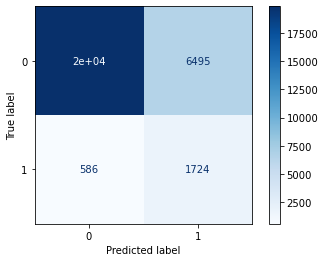

In [79]:
evaluation_df=model_eval(logreg_under, 2, X_train_rus, y_train_rus, X_test_dum, y_test, 'logistic regression with undersampling')

The F1 scores seem to have improved a lot with undersampling. Balanced accuracy (0.75) and recall (0.75) have also improved. Confusion matrix shows 6495 false positives and 586 false negatives.

**Model 3: ADASYN-Logistic Regression**

Trying oversampling with logistic regression

In [81]:
pipe=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('logreg', LogisticRegression(n_jobs=-1))
])

logreg_ada_param={
    'ada__sampling_strategy':[0.5,.75,1]}
   

gs_ada=GridSearchCV(pipe,
               param_grid=logreg_ada_param,
                scoring='balanced_accuracy',
               cv=5)

In [82]:
gs_ada.fit(X_train_dum, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1]},
             scoring='balanced_accuracy')

Model: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1]},
             scoring='balanced_accuracy')
Training_score: 0.7507074135488199
Testing score: 0.7429725922819164
F1 Train score: 0.33219789132197886
F1 Test score: 0.32525213343677273
Balanced Accuracy: 0.7429725922819164
Recall: 0.7259740259740259
Precision: 0.20957260684828793


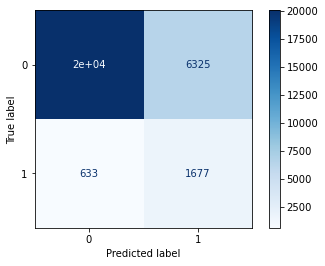

In [83]:
evaluation_df=model_eval(gs_ada, 3, X_train_dum, y_train, X_test_dum, y_test, 'logistic regression with ADASYN')

In [85]:
gs_ada.best_params_

{'ada__sampling_strategy': 1}

Balanced accuracy and recall are comparable to the previous model. F1 train score is low.  
Number of false positives and false negatives also look similar.

**Model 3.2: ADASYN-Logistic Regression without GridSearch**

In [86]:
ada2=ADASYN(random_state=42)
X_train_ada,y_train_ada=ada2.fit_resample(X=X_train_dum, y=y_train)

In [87]:
logreg_ada=LogisticRegression(solver='liblinear', max_iter=500)

logreg_ada.fit(X_train_ada,y_train_ada)

LogisticRegression(max_iter=500, solver='liblinear')

Model: LogisticRegression(max_iter=500, solver='liblinear')
Training_score: 0.7580914879250832
Testing score: 0.7581731272460835
F1 Train score: 0.7571843903798526
F1 Test score: 0.3247929858743303
Balanced Accuracy: 0.7415101507602742
Recall: 0.7216450216450216
Precision: 0.20955373978629793


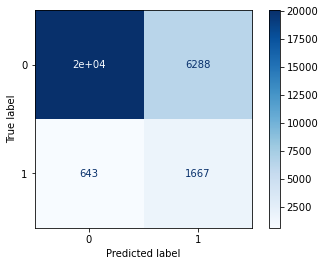

In [89]:
evaluation_df=model_eval(logreg_ada, 4, X_train_ada, y_train_ada, X_test_dum, y_test, 'logistic regression with ADASYN2')

This model scored very similar to the Logistic regression with under sampling. 
Balanced accuracy is 0.74, recall is 0.72.  

**Model 4: KNeighbors with SMOTENN**  
Since the features are all categorical, trying SMOTENN(combination of over and under sampling)  
help from: https://imbalanced-learn.org/stable/combine.html#combine

In [34]:
sm= SMOTEENN(random_state=42)

In [35]:
X_train_sm,y_train_sm=sm.fit_resample(X_train_dum,y_train)

In [36]:
knn=KNeighborsClassifier()

In [49]:
pipe=Pipeline([
    ('sm', SMOTEENN(random_state=42)),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

knn_param={
    'sm__sampling_strategy':[.75,1],
    'knn__n_neighbors':[5,10,15],
    # 'knn__weights': ['uniform','distance'], 
    # 'knn__p':[1,2]
    }

gs_knn=GridSearchCV(pipe,
                   param_grid=knn_param,
                   scoring='balanced_accuracy',
                   cv=5)

In [50]:
gs_knn.fit(X_train_dum,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTEENN(random_state=42)),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'knn__n_neighbors': [5, 10, 15],
                         'sm__sampling_strategy': [0.75, 1]},
             scoring='balanced_accuracy')

Model: KNeighborsClassifier()
Training_score: 0.694055750823441
Testing score: 0.918983985206378
F1 Train score: 0.5299551691346285
F1 Test score: 0.2855384615384615
Balanced Accuracy: 0.5914009851355683
Recall: 0.20086580086580086
Precision: 0.49361702127659574


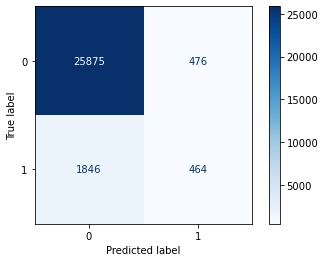

In [115]:
evaluation_df=model_eval(knn, 4, X_train_sm, y_train_sm, X_test_dum, y_test, 'KNN with SMOTENN')

In [96]:
gs_knn.best_params_

{'knn__n_neighbors': 10, 'sm__sampling_strategy': 1}

This model has lower balanced accuracy (0.59) and recall (0.2).  It has considerable higher false negatives as shown in the confusion matrix display.

**Model 5: Multinomial Naive Bayes with SMOTENN**

In [91]:
nb=MultinomialNB()

In [92]:
nb.fit(X_train_sm,y_train_sm)

MultinomialNB()

Model: MultinomialNB()
Training_score: 0.6635939606958905
Testing score: 0.9016084574857821
F1 Train score: 0.481145584725537
F1 Test score: 0.1561938958707361
Balanced Accuracy: 0.5418640806652647
Recall: 0.11298701298701298
Precision: 0.25290697674418605


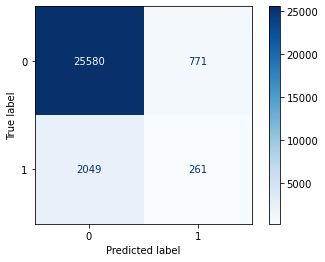

In [114]:
evaluation_df=model_eval(nb, 5, X_train_sm, y_train_sm, X_test_dum, y_test, 'MNB with SMOTENN')

This model also has low balanced accuracy (0.54) and very low recall (0.11).  
Also, shows more false negatives in the confusion matrix display.

**Model 6: AdaBOOST with ADASYN**

In [108]:

pipe_adab=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('adab', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)),
])

adab_param={
     'ada__sampling_strategy':[.8,1],
    'adab__n_estimators': [50,100],
    'adab__base_estimator__max_depth':[1,3],
    'adab__base_estimator__min_samples_split':[2,3],
    'adab__learning_rate':[0.9,1.0],
            }

gs_adab=GridSearchCV(pipe_adab,
                  param_grid=adab_param,
                  cv=3,
                  n_jobs=-1)


gs_adab.fit(X_train_dum,y_train);


Model: GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('adab',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'ada__sampling_strategy': [0.8, 1],
                         'adab__base_estimator__max_depth': [1, 3],
                         'adab__base_estimator__min_samples_split': [2, 3],
                         'adab__learning_rate': [0.9, 1.0],
                         'adab__n_estimators': [50, 100]})
Training_score: 0.8081830129211588
Testing score: 0.8053103520463347
F1 Train score: 0.34178073991299834
F1 Test score: 0.3350810295519543
Balanced Accuracy: 0.7156037187610942
Recall: 0.6086580086580087
Precision: 0.23117395593554751


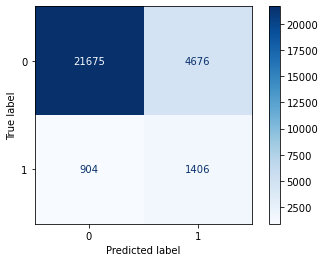

In [109]:
evaluation_df=model_eval(gs_adab, 6, X_train_dum, y_train, X_test_dum, y_test, 'AdaBoost with ADASYN')

In [110]:
gs_adab.best_estimator_

Pipeline(steps=[('ada', ADASYN(random_state=42, sampling_strategy=0.8)),
                ('adab',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.9, random_state=42))])

This model is comparable to logistic regression models in terms of balanced accuracy (0.72) and recall.

**Model 7: Gradient Boost with ADASYN**

In [266]:

pipe_gdb=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('gdb', GradientBoostingClassifier(random_state=42)),
])

gdb_param={
     'ada__sampling_strategy':[.8,1],
    'gdb__n_estimators': [50,100],
    'gdb__max_depth':[1,3],
    'gdb__min_samples_split':[2,3],
    'gdb__learning_rate':[0.9,1.0],
            
    }


gs_gdb=GridSearchCV(pipe_gdb,
                  param_grid=gdb_param,
                  cv=3,
                  n_jobs=-1)


gs_gdb.fit(X_train_dum,y_train);


Model: GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('gdb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'ada__sampling_strategy': [0.8, 1],
                         'gdb__learning_rate': [0.9, 1.0],
                         'gdb__max_depth': [1, 3],
                         'gdb__min_samples_split': [2, 3],
                         'gdb__n_estimators': [50, 100]})
Training_score: 0.8059732737866787
Testing score: 0.8037751648581697
F1 Train score: 0.3394179370421698
F1 Test score: 0.33270052206929285
Balanced Accuracy: 0.713978933416526
Recall: 0.606926406926407
Precision: 0.2291598561621445


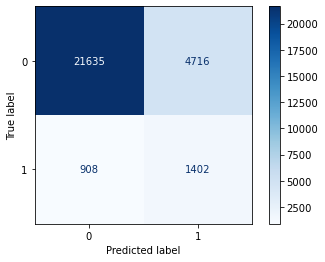

In [267]:
evaluation_df=model_eval(gs_gdb, 7, X_train_dum, y_train, X_test_dum, y_test, 'GradientBoost with ADASYN')

In [269]:
gs_gdb.best_estimator_

Pipeline(steps=[('ada', ADASYN(random_state=42, sampling_strategy=0.8)),
                ('gdb',
                 GradientBoostingClassifier(learning_rate=0.9, max_depth=1,
                                            n_estimators=50,
                                            random_state=42))])

This model is also comparable to AdaBoost and logistic regression in terms of target metrics.

## Binary classification including Symptom_status
**Complete hosp data (removed/unknown values in 'hosp_yn' is imputed as 0)**

Here we are taking all the data points in hosp_yn columns, the unknown and missing values are replaced with 'No' (0).  
We are also adding one more column- 'symptom_status' as it might be helpful as another feature to train the model.

In [639]:
#Reading the data
df_surv_hosp2=pd.read_csv('../data/clean_data/covid_surveillance_hospitalization_comp.csv')

In [564]:
df_surv_hosp2.head()

,case_month,res_state,age_group,sex,race,ethnicity,symptom_status,hosp_yn,death_yn
0,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,Unknown
1,2020-03-01,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Symptomatic,0,No
2,2020-03-01,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
3,2020-03-01,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,No
4,2020-03-01,IA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,0,Missing


In [565]:
df_surv_hosp2.shape

(122787, 9)

### Creating month as a new feature

In [640]:
def create_month(df):
    
    #converting case_month to DateTime
    df['case_month']=pd.to_datetime(df['case_month'])

    #Extracting month as a feature for the model
    df['month']=df['case_month'].dt.month

    #All our columns will be treated as categorical. Converting month column to object type.
    df['month']=df['month'].astype(object)

    return df

In [641]:
df_surv_hosp2=create_month(df_surv_hosp2)

In [642]:
df_surv_hosp2.shape

(122787, 10)

In [643]:
df_surv_hosp2.head();

### Baseline- Model Benchmark

In [645]:
df_surv_hosp2['hosp_yn'].value_counts(normalize=True)

0    0.955052
1    0.044948
Name: hosp_yn, dtype: float64

We have highly **imbalanced classes** for our target variable.  
Our baseline accuracy is 96%

### X,y, Train Test Split

In [597]:
#Creating X and y
X2=df_surv_hosp2.drop(columns=['case_month','death_yn','hosp_yn'])
y2=df_surv_hosp2['hosp_yn']
features2=list(X.columns)

In [598]:
X2.shape, y2.shape

((122787, 7), (122787,))

In [599]:
X2.head()

,res_state,age_group,sex,race,ethnicity,symptom_status,month
0,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,3
1,NJ,18 to 49 years,Female,Black,Non-Hispanic/Latino,Symptomatic,3
2,PA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,3
3,MI,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,3
4,IA,18 to 49 years,Female,White,Non-Hispanic/Latino,Symptomatic,3


In [600]:
y2.head()

0    0
1    0
2    0
3    0
4    0
Name: hosp_yn, dtype: int64

In [601]:
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,stratify=y2, random_state=42)

In [602]:
X2_train.shape, y2_train.shape, X2_test.shape,y2_test.shape

((92090, 7), (92090,), (30697, 7), (30697,))

In [603]:
X2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92090 entries, 20278 to 94961
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   res_state       92090 non-null  object
 1   age_group       92090 non-null  object
 2   sex             92090 non-null  object
 3   race            92090 non-null  object
 4   ethnicity       92090 non-null  object
 5   symptom_status  92090 non-null  object
 6   month           92090 non-null  object
dtypes: object(7)
memory usage: 5.6+ MB


### One hot encoding

In [609]:
#Getting some future warning with this-- tried finding the solution online but this one seems to be an open issue so far
#not suppressing it for the record

dropped_col_guide2, X2_train_dum, X2_train_dummies=transform_train(X2_train, features2)

C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [610]:
#Getting some future warning with this-- tried finding the solution online but this one seems to be an open issue so far
#not suppressing it for the record

X2_test_dum=transform_test(X2_test, X2_train_dummies, features2)

C:\Users\deepi\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [616]:
pd.DataFrame(X2_train_dummies).to_csv('../streamlit/pages/models/X2_train_dummies.csv', index=False)

In [617]:
X2_train_dum.shape, y2_train.shape, X2_test_dum.shape, y2_test.shape

((92090, 66), (92090,), (30697, 66), (30697,))

In [607]:
# X2_test_dum=X2_test_dum[X2_train_dummies]

### Model Tuning

**Model 8: ADASYN-Logistic Regression**

In [212]:
pipe=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('logreg', LogisticRegression(n_jobs=-1))
])

logreg_ada_param={
    'ada__sampling_strategy':[0.5,.75,1]}
   

gs_ada2=GridSearchCV(pipe,
               param_grid=logreg_ada_param,
                scoring='balanced_accuracy',
               cv=5)

In [213]:
gs_ada2.fit(X2_train_dum, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1]},
             scoring='balanced_accuracy')

Model: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'ada__sampling_strategy': [0.5, 0.75, 1]},
             scoring='balanced_accuracy')
Training_score: 0.7419166186698287
Testing score: 0.7497680526656888
F1 Train score: 0.23003246753246753
F1 Test score: 0.23495074790222545
Balanced Accuracy: 0.7497680526656888
Recall: 0.7
Precision: 0.14116615519508988


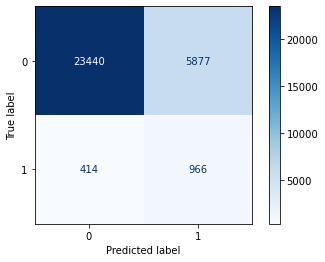

In [278]:
evaluation_df=model_eval(gs_ada2, 8, X2_train_dum, y2_train, X2_test_dum, y2_test, 'logistic regression with ADASYN -comp data w/Symptom')

In [279]:
gs_ada.best_params_

{'ada__sampling_strategy': 1}

This model also has comparable balanced accuracy (0.75) and recall (0.7) to some of the previous models.

**Model 9: Logistic Regression with Undersampling**

In [620]:
#Help from lesson 7.06
rus2=RandomUnderSampler(random_state=42)

X2_train_rus,y2_train_rus=rus.fit_resample(X2_train_dum,y2_train)

In [621]:
X2_train_rus.shape, y2_train_rus.shape

((8278, 66), (8278,))

In [622]:
logreg_under2=LogisticRegression(max_iter=200)

logreg_under2.fit(X2_train_rus,y2_train_rus)

LogisticRegression(max_iter=200)

In [275]:
y2_test;

Model: LogisticRegression(max_iter=200)
Training_score: 0.7591205605218652
Testing score: 0.7567514740854155
F1 Train score: 0.7550970277573079
F1 Test score: 0.21721354439668725
Balanced Accuracy: 0.7538799024951146
Recall: 0.7507246376811594
Precision: 0.12697634514033582


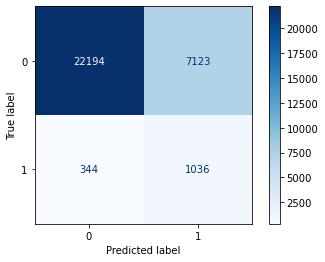

In [623]:
evaluation_df=model_eval(logreg_under2, 9, X2_train_rus, y2_train_rus, X2_test_dum, y2_test, 'logistic regression with undersampling-comp data w/symptom')

This model has one of the best scores- balanced accuracy (0.75) and recall (0.75) among all the models we tried so far.

**Model 10 Gradient Boost with ADASYN**

In [559]:

pipe_gdb=Pipeline([
    ('ada', ADASYN(random_state=42)),
    ('gdb', GradientBoostingClassifier(random_state=42)),
])

gdb_param={
     'ada__sampling_strategy':[.8,1],
    'gdb__n_estimators': [50,100],
    'gdb__max_depth':[1,3],
    'gdb__min_samples_split':[2,3],
    'gdb__learning_rate':[0.9,1.0,1.1],
            
    }


gs_gdb2=GridSearchCV(pipe_gdb,
                  param_grid=gdb_param,
                  cv=3,
                  n_jobs=-1)


gs_gdb2.fit(X2_train_dum,y2_train);


Model: GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ada', ADASYN(random_state=42)),
                                       ('gdb',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'ada__sampling_strategy': [0.8, 1],
                         'gdb__learning_rate': [0.9, 1.0, 1.1],
                         'gdb__max_depth': [1, 3],
                         'gdb__min_samples_split': [2, 3],
                         'gdb__n_estimators': [50, 100]})
Training_score: 0.8338364643283744
Testing score: 0.8363032218132065
F1 Train score: 0.2507100186073842
F1 Test score: 0.2602679228617695
Balanced Accuracy: 0.7430479817566402
Recall: 0.6405797101449275
Precision: 0.16331054867910585


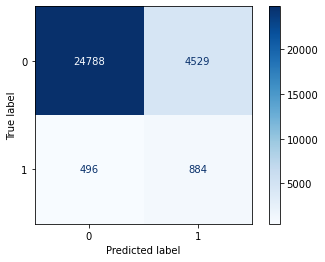

In [612]:
evaluation_df=model_eval(gs_gdb2, 10, X2_train_dum, y2_train, X2_test_dum, y2_test, 'GradientBoost with ADASYN-comp data w/symptom')

This model is also comparable - balanced accuracy: 0.74, but recall is a little lower: 0.64.

### Model Evaluation

In [614]:
evaluation_df.sort_values(by='recall', ascending=False)

,model_no,comment,training_accuracy,testing_accuracy,f1score_train,f1score_test,balanced_accuracy,recall,precision
8,9,logistic regression with undersampling-comp da...,0.759121,0.756751,0.755097,0.217214,0.75388,0.750725,0.126976
1,2,logistic regression with undersampling,0.749747,0.75294,0.751041,0.327476,0.74992,0.74632,0.209758
2,3,logistic regression with ADASYN,0.750707,0.742973,0.332198,0.325252,0.742973,0.725974,0.209573
7,8,logistic regression with ADASYN -comp data w/S...,0.741917,0.749768,0.230032,0.234951,0.749768,0.7,0.141166
9,10,GradientBoost with ADASYN-comp data w/symptom,0.833836,0.836303,0.25071,0.260268,0.743048,0.64058,0.163311
5,6,AdaBoost with ADASYN,0.808183,0.80531,0.341781,0.335081,0.715604,0.608658,0.231174
6,7,GradientBoost with ADASYN,0.805973,0.803775,0.339418,0.332701,0.713979,0.606926,0.22916
3,4,KNN with SMOTENN,0.694056,0.918984,0.529955,0.285538,0.591401,0.200866,0.493617
4,5,MNB with SMOTENN,0.663594,0.901608,0.481146,0.156194,0.541864,0.112987,0.252907
0,1,logistic regression,0.921892,0.921287,0.125749,0.115294,0.530054,0.063636,0.6125


In [615]:
evaluation_df.to_csv('../data/covid_demo_model_evaluation.csv')

## Production Model Insights

**Logistic Regression with Under Sampling**

From the evaluation summary table above, our best model is Logistic Regression with Undersampling (with complete dataset and symptom as additional feature) with **Balanced Accuracy of 0.75** and **Recall of 0.75.** Looking at confusion matrix, it has lowest false negatives (344) among all the models and will be considered our production model.

In [669]:
pred=logreg_under2.predict(X2_test_dum)

In [671]:
tn,fp,fn,tp=confusion_matrix(y2_test, pred).ravel()
print(f'True positive: {tp}\nFalse positive: {fp}\nTrue negative: {tn}\nFalse negative:{fn}')

True positive: 1036
False positive: 7123
True negative: 22194
False negative:344


In [672]:
#Specificity
spec=tn/(tn+fp)
print(f'Specificity: {spec}')

Specificity: 0.7570351673090698


In [673]:
#Misclassification
print(f'Misclassification: {(fp+fn)/(tp+fp+tn+fn)}')

Misclassification: 0.24324852591458448


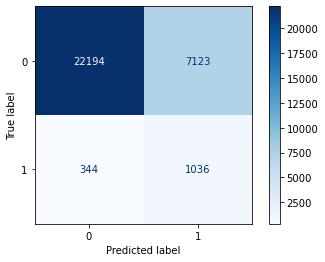

In [664]:
ConfusionMatrixDisplay.from_estimator(logreg_under2,X2_test_dum, y2_test, cmap='Blues')
plt.savefig('../image/confusion_matrix_surv.png');

The model has a specificity of 0.75, sensitivity (recall) of 0.75 and a misclassification rate of 0.24.


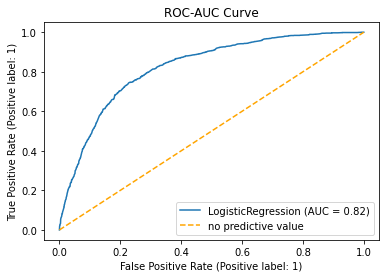

In [675]:
#Looking ROC-AUC curve
RocCurveDisplay.from_estimator(logreg_under2,X2_test_dum,y2_test)

# add 'worst case scenario' line
plt.plot([0,1],[0,1],label='no predictive value', linestyle='--',color='orange')

# add a legend
plt.legend();
plt.title('ROC-AUC Curve')
plt.savefig('../image/roc_auc.png');

The ROC AUC curve is not perfect but still seems to indicate separation between the two classes. The model can be tuned more by adding more features that can affect the probability of hospitalization. Next steps could be to explore some more features, get more observations and try some other classification and under/over sampling techniques

**Understanding the feature importance**

In [627]:
logreg_under2.coef_

array([[-0.35636776,  0.11868702,  0.07303625,  0.37922229, -0.34239965,
         0.20907307,  0.5087432 , -0.1759902 , -3.15881795, -0.93806549,
        -0.08958603,  0.08884629,  0.66840233,  1.29189364,  0.8920934 ,
        -0.14147979, -0.13305946, -0.245681  , -0.34623395, -0.14574996,
         0.56139622, -0.07754836,  0.37507184,  0.06921095, -1.40183921,
        -1.37849125,  1.37500828,  0.24285059,  0.83763444,  0.28606228,
         0.71955482,  0.74138088,  0.07553447, -1.19116969, -0.39703005,
        -1.84505875, -0.15351139,  0.44987454, -1.93916576, -0.28142786,
        -0.76807158, -0.1003554 , -0.0184413 ,  0.28843812,  0.81404273,
         1.91687895,  3.30636732,  0.14552655, -0.80104207, -0.13727398,
        -0.82836201, -0.68068251, -1.07834553, -0.24561406,  0.49821355,
        -0.012544  ,  0.84507191,  0.58833115,  0.8425206 ,  0.4399378 ,
         0.569099  ,  0.54615999,  0.35429896,  0.46884332,  0.39558718,
         0.18816045]])

In [668]:
X2_train_rus_features=X2_train_rus.columns[:]
model9_coef_df=pd.DataFrame({'factor': X2_train_rus_features, 'coefficients': logreg_under2.coef_[0]})
model9_coef_df.sort_values('coefficients',ascending=False, inplace=True)
model9_coef_df['exp_coef']=model9_coef_df['coefficients'].map(lambda x: np.exp(x))
model9_coef_df.to_csv('../streamlit/pages/models/logreg2_coef.csv')
model9_coef_df2=model9_coef_df[['factor','exp_coef']].copy()
model9_coef_df2.rename(columns={'factor': 'Factor','exp_coef': 'Exp(coef)'})
model9_coef_df2.head(10)

,factor,exp_coef
46,age_group_65+ years,27.285825
45,age_group_50 to 64 years,6.799703
26,res_state_NJ,3.955109
13,res_state_KS,3.639672
14,res_state_KY,2.440233
56,month_3,2.328145
58,month_5,2.322213
28,res_state_NV,2.310894
44,age_group_18 to 49 years,2.257014
31,res_state_OK,2.098832


In [649]:
logreg_under.intercept_

array([-0.48107927])

The coefficient table above shows the ten most significant features in this predictive model. It shows that the age groups 65+ year and 50-64 year and the locations NJ, KS and KY are among the five most significant factors that affect the hospitalization. For example, if someone is in age group 65+, they are 27 times (looking at the exp_coefficient) as likely to be hospitalized when compared to someone in 1-17 years age group (reference form the col guide shown below). This suggests that the states/counties that have higher population in these age groups might need more resource allocations, support and preparations to prevent hospitalizations. The table also lists some of the states like New Jersey, Kensas, Kentucky indicating that thes locations may need more close attention with regards to future surges and should be kept prepared to handle uprise in hospitalizations. 

In [647]:
dropped_col_guide2

Index(['res_state_AK', 'res_state_AL', 'res_state_AR', 'res_state_AZ',
       'res_state_CA', 'res_state_CO', 'res_state_CT', 'res_state_DC',
       'res_state_FL', 'res_state_GA', 'res_state_HI', 'res_state_IA',
       'res_state_ID', 'res_state_IN', 'res_state_KS', 'res_state_KY',
       'res_state_LA', 'res_state_MA', 'res_state_MD', 'res_state_ME',
       'res_state_MI', 'res_state_MN', 'res_state_MO', 'res_state_MT',
       'res_state_NC', 'res_state_NE', 'res_state_NH', 'res_state_NJ',
       'res_state_NM', 'res_state_NV', 'res_state_NY', 'res_state_OH',
       'res_state_OK', 'res_state_OR', 'res_state_PA', 'res_state_SC',
       'res_state_SD', 'res_state_TN', 'res_state_TX', 'res_state_UT',
       'res_state_VA', 'res_state_VT', 'res_state_WA', 'res_state_WI',
       'res_state_WY', 'age_group_0 - 17 years', 'age_group_18 to 49 years',
       'age_group_50 to 64 years', 'age_group_65+ years', 'sex_Female',
       'sex_Male', 'race_American Indian/Alaska Native', 'race_Asian',

In [652]:
prob=logreg_under2.predict_proba(X2_test_dum)

In [656]:
prob

array([[0.90474725, 0.09525275],
       [0.87150317, 0.12849683],
       [0.78027334, 0.21972666],
       ...,
       [0.94669307, 0.05330693],
       [0.83215069, 0.16784931],
       [0.96543261, 0.03456739]])

In [659]:
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Pickling production model

In [626]:
with open('../streamlit/pages/models/demo_model_logreg2.pkl', 'wb') as m:
    pickle.dump(logreg_under2, m)